In [15]:
import os
import cv2
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fracture
import DIC as dic

#csv파일 형식 바꾸기!

"""setting values"""
path = r'E:\experiment data\aluminum\2021-03-25\faruv_tension_2'
path_save= r'E:\experiment data\aluminum\2021-03-25\faruv_tension_2'

slice_x1 = 71
slice_x2 = 142
slice_y1 = 414
slice_y2 = 661

file_list = os.listdir(path+'/img')

result = []
for file in file_list:
    if file.endswith(".jpg"):
        im = cv2.imread(os.path.join(path,'img', file), cv2.IMREAD_GRAYSCALE)
        im_calculate = np.array(im)
        img_box = im_calculate[slice_y1:slice_y2, slice_x1:slice_x2]

        ave = np.average(img_box)
        result = np.append(result, [ave])

ml_avg = np.copy(result)
print('Finish')

(17395,)
Done


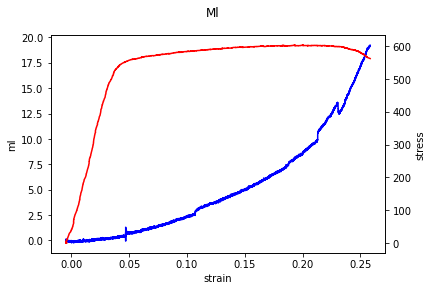

In [17]:
from scipy.signal import savgol_filter

max_range = 16741
tension_data = np.array(pd.read_csv(path+'/tension.csv', encoding='CP949'))

time, strain, stress = tension_data[:, 0], tension_data[:, 4]*10/25, tension_data[:, 3]*3000/18

stress = savgol_filter(stress[0:max_range],201,1)
strain = savgol_filter(strain[0:max_range],201,1)
# ml_avg = savgol_filter(ml_avg[0:max_range],6001,1)
ml_avg =  ml_avg[0:max_range]
time = time[0:max_range]

ml_avg[3545:] = ml_avg[3545:] + 1.4

fig, ax = plt.subplots()
ax1 = ax.twinx()
fig.suptitle('Ml')
ax.set_xlabel('strain')
ax.set_ylabel('ml')
ax1.set_ylabel('stress')
ax.plot(strain, ml_avg-ml_avg[0], color='b', label="Average Ml(Same mask)")
ax1.plot(strain, stress, color='r', label=" stress")

In [106]:

"""
Matlab코드 여러 Dic데이터있는경우
path = r'E:\experiment data/aluminum\Current/tension/data'

for i=1:1:22
uu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end

"""

"""setting values"""

image = dic.load_file(path+'/DIC_img')

ref = image[list(image.keys())[0]]
ref_x, ref_y = 105, 580

ratio = 0.04
dataframe = pd.DataFrame([[0,1,2,3,4,5,6,7,8]],columns=['image_name', 'voltage_strain','DIC_strain_average', 'using_DIC_mask_average', 'local_ml', 'local_ee','DIC_exx', 'DIC_eyy', 'DIC_exy'])

row = pd.Series(['image_name', 'voltage_strain','DIC_strain_average', 'using_DIC_mask_average', 'local_ml', 'local_ee','DIC_exx', 'DIC_eyy', DIC_exy],
                index=['image_name', 'voltage_strain','DIC_strain_average', 'using_DIC_mask_average', 'local_ml', 'local_ee','DIC_exx', 'DIC_eyy', 'DIC_exy'])


,image_name,voltage_strain,DIC_strain_average,using_DIC_mask_average,local_ml,local_ee,DIC_exx,DIC_eyy,DIC_exy
0,0,1,2,3,4,5,6,7,8
1,0,1,2,3,4,5,6,7,8
2,1,1,2,3,4,5,6,7,8


In [ ]:
for num in range(1,2+1):
    file_num = str(num)
    uu = io.loadmat(path+'/DIC_img/data/'+file_num+'_uu.mat')['uu']
    vv = io.loadmat(path+'/DIC_img/data/'+file_num+'_vv.mat')['vv']
    uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
    vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )

    exx = io.loadmat(path+'/DIC_img/data/'+file_num+'_exx.mat')['exx']
    eyy = io.loadmat(path+'/DIC_img/data/'+file_num+'_eyy.mat')['eyy']
    exy = io.loadmat(path+'/DIC_img/data/'+file_num+'_exy.mat')['exy']
    ee = fracture.effective_strain(exx, eyy, exy)
    exx_resize = cv2.resize(exx,(0,0),fx=2, fy=2 )
    eyy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
    exy_resize = cv2.resize(exy,(0,0),fx=2, fy=2 )
    ee_resize = cv2.resize(ee,(0,0),fx=2, fy=2 )

    ee_mask = np.where(ee_resize>0, 255, ee_resize*0).astype('uint8')
    ml_image = image[list(image.keys())[num]]
    mask_ml = dic.find_zone(cv2.copyTo(ml_image, ee_mask))[10:-10,10:-10]
    if num == 1:
        ref_image = cv2.copyTo(image[list(image.keys())[0]], cv2.imread(path+'/DIC_img/mask.png'))
        ref = dic.find_zone(ref_image)[10:-10,10:-10]
        gas_ref = cv2.GaussianBlur(ref,(0,0),5)

    gas = cv2.GaussianBlur(mask_ml[:,:,1],(0,0),5)

    cur_y = np.round(ref_y+vv_resize[ref_y,ref_x]/ratio,1).astype('int')
    cur_x = np.round(ref_x+uu_resize[ref_y,ref_x]/ratio,1).astype('int')

    local_ee = np.average(ee_resize[cur_y-10 : cur_y+10 , cur_x-10: cur_x+10])
    local_ml = np.average(ml_image[cur_y-10 : cur_y+10 , cur_x-10: cur_x+10]) - np.average(image[list(image.keys())[0]][ref_y-10 : ref_y+10 , ref_x-10 : ref_x+10])

    if num > 6:
        local_ml = local_ml + 1.4


    fig, ax = plt.subplots(1, 3 , constrained_layout=True)
    fig.suptitle(list(image.keys())[num] + 'strain : ' + str(np.round(strain[int(list(image.keys())[num].split('_')[1])],3)))

    ax0 = ax[0].imshow(cv2.addWeighted(ml_image[:,:,2],1, ee_mask,0.06,-40),cmap='gray')
    ax[0].set_title('ML ROI')
    ax[0].scatter(cur_x, cur_y,color='red', marker='s', s=10)

    ax1 = ax[1].imshow(ee_resize, cmap='jet', vmin=0, vmax=0.25)
    ax[1].set_title('Effective\n strain')
    ax[1].scatter(cur_x, cur_y,color='white', marker='s', s=10)
    plt.colorbar(ax1,ax=ax[1])

    gas = cv2.flip(gas,0)
    ax[2].imshow(gas)
    ax2 = ax[2].contourf(gas,cmap='jet', vmin=75, vmax=116)
    ax3 = ax[2].contour(gas,colors='black',linewidths=1)
    ax[2].invert_yaxis()
    plt.colorbar(ax2, ax=ax[2])
    # ax[2].axis('off')
    ax[2].set_title('ML')

    image_name = int(list(image.keys())[num].split('_')[1])
    voltage_strain = strain[int(list(image.keys())[num].split('_')[1])]
    DIC_strain_average = np.average(dic.find_zone(ee_resize)[10:-10,10:-10])
    using_DIC_mask_average = np.average(mask_ml[:,:,1])-np.average(ref)
    local_ml = local_ml
    local_ee = local_ee
    DIC_eyy = np.average(dic.find_zone(eyy))
    DIC_exx = np.average(dic.find_zone(exy))
    DIC_exy = np.average(dic.find_zone(exy))

    # plt.savefig(path_save+'/'+list(image.keys())[num]+'.png', dpi=300)
    plt.show()
    plt.close()


plt.imshow(ee_resize, cmap='PuBu', vmin=0, vmax=0.25) ##네킹부분 국부
plt.scatter(cur_x, cur_y, marker='s', s=10  ,label='x:'+str(ref_x) + ' y:'+str(ref_y), edgecolors='black')
plt.legend()
plt.legend(loc='center right', bbox_to_anchor=(2.9, 0.5), fancybox=True, shadow=True)
# plt.savefig(path_save+'/국부 점으로찍은위치6.png', dpi=300)


In [ ]:
fig, ax1 = plt.subplots()
fig.subplots_adjust()


for _ in local_list_all:
    ax1.scatter(np.array(local_list_all)[:,0], np.array(local_list_all)[:,1], label='x:'+str(ref_x) + ' y:'+str(ref_y), marker='X')

    # ax1.legend(loc='center right', bbox_to_anchor=(1.2, 0.4), fancybox=True, shadow=True)
cost_list = []

fp1 = np.polyfit(np.array(local_list_all_2d)[:,0], np.array(local_list_all_2d)[:,1], 1)
f1 =np.poly1d(fp1)
x_fit = np.arange(0,0.25,0.0005)
ax1.plot(x_fit, f1(x_fit), color='black')
ax1.set_ylabel('ml')
ax1.set_xlabel('effective_strain')
ax1.grid()
ax1.set_title('Local effective strain vs Local ML intensity_degree:1')
ax1.plot(x_fit, x_fit*109.1)

plt.plot(np.array(ee_list)[:,1],np.array(ee_list)[:,2], color='red')
plt.axvspan(0, 0.0285, facecolor='gray', alpha=0.5)

plt.savefig(path_save+'/1.3더한거커브.png', dpi=300, bbox_inches='tight',  pad_inches=0)

In [ ]:
b = np.vstack((x_fit, 109.1*x_fit)).transpose()

np.savetxt(path_save+'/effective_strain_ml_1.3더한거.csv',b)

In [ ]:
"""평균"""

fig, ax = plt.subplots()
ax1 = ax.twinx()
fig.suptitle('Ml')
ax.set_xlabel('strain')
ax.set_ylabel('ml')
ax1.set_ylabel('stress')
line1 = ax.plot(strain, ml_avg-ml_avg[0], color='b', label="Same mask vs Average Ml")
line3 = ax1.plot(strain, stress, color='r', label=" stress")
# scatter1 = ax.plot(np.array(ee_list)[:,0].astype('float'), np.array(ee_list)[:,2].astype('float'), color = 'green', label='different mask')
# line2 = ax.plot(np.array(ee_list)[:,0].astype('float'), np.array(ee_list)[:,4].astype('float'), label='Necking average')
# ax.plot(x_fit, f1(x_fit), color='green', linewidth=2, label = 'fitting(Effective strain vs Ml)')

ax.plot()

lines = line1
labels = [l.get_label() for l in lines]
ax.legend(loc = 4)

ax1.legend(loc = 2)
ax.grid()

fig.savefig(path_save+'/평균ml_평균1.3ejgksrjdicgraph1.png', dpi = 300)
plt.show()
plt.close()

In [ ]:
plt.plot(time,strain, label='Stress-strain')
plt.scatter(np.array(ee_list)[:,3].astype('uint'), np.array(ee_list)[:,1].astype('float'), label='Effective strain', color='red')
plt.xlabel('time')
plt.ylabel('strain')
plt.legend()

# plt.savefig(path_save+'/평균ml_평균dicgraph1.png', dpi = 300)
plt.show()

In [ ]:
plt.scatter(np.array(ee_list)[:,0].astype('float'),np.array(ee_list)[:,1].astype('float'),label='effective strain')
plt.legend()
plt.xlabel('Eyy')
plt.ylabel('Ee')
plt.show()

In [ ]:
plt.scatter(np.array(ee_list)[:,1].astype('float'),np.array(ee_list)[:,0].astype('float'),label='Eyy')
plt.legend()
plt.xlabel('Ee')
plt.ylabel('Eyy')

In [ ]:
fig, ax = plt.subplots()
ax1 = ax.twinx()

ax1.plot(np.array(ee_list)[:,0], np.array(ee_list)[:,5], label='eyy')
ax1.plot(np.array(ee_list)[:,0], np.array(ee_list)[:,6], label='exx')
ax1.plot(np.array(ee_list)[:,0], np.array(ee_list)[:,7], label='exy')
ax1.scatter(np.array(ee_list)[:,0], np.array(ee_list)[:,1], label='effective strain', color='purple')
ax1.plot(np.array(ee_list)[:,0], np.array(ee_list)[:,0], label='cross head strain')
ax.plot(strain, stress, color='black', label=" stress")

ax1.set_ylabel('strain')
ax.set_ylabel('stress')
ax.set_xlabel('Crosshead strain')
ax.set_ylim(-200,)

ax.grid()
ax1.legend()
plt.savefig(path_save+'/비교.png', dpi = 300)

In [ ]:
plt.plot(np.array(ee_list)[:,5], np.array(ee_list)[:,4], label='eyy')
plt.xlabel('dic strain eyy')

In [ ]:
plt.plot(np.array(ee_list)[:,0], np.array(ee_list)[:,4], label='eyy')
plt.xlabel('Crosshead strain')

In [ ]:
true_stress,true_strain = fracture.true_ss(stress, strain)
plt.plot(true_strain, true_stress)
plt.plot(strain,stress)
